In [1]:
cd /sfs/fs1/work-geomar1/smomw184/ANA/ORCA025.L46/coarse_graining/fig3_Qnet

/sfs/fs1/work-geomar1/smomw184/ANA/ORCA025.L46/coarse_graining/fig3_Qnet


In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from netCDF4 import Dataset
from haversine import haversine
import matplotlib.gridspec as gridspec
from mpl_toolkits.basemap import Basemap
from matplotlib.patches import Polygon
import cmocean as cm
from matplotlib import ticker

def coarsening(var,fact):
    '''Data will be coarsed by factor fac'''
    assert isinstance(fact, int), type(fact)
    sy, sx = var.shape
    var_out=var.copy()*np.nan
    for i in np.arange(fact,sx+fact,fact):
        for j in np.arange(fact,sy+fact,fact):
            var_out[j-fact:j,i-fact:i]=np.nanmean(var[j-fact:j,i-fact:i].flatten(),0)
    return var_out

def coarsening_all(x1,x2,y1,y2,u,v,sst, fact):
    '''Change in percent relative to not coarsening'''
    U=u[:,y1:y2,x1:x2]
    V=v[:,y1:y2,x1:x2]
    SST=sst[:,y1:y2,x1:x2]

    Uc=U.copy()*np.nan
    Vc=Uc.copy()
    SSTc=Uc.copy()
    t_dim,y_dim,x_dim=U.shape
    for t in np.arange(t_dim):
        Uc[t,:,:]=coarsening(U[t,:,:],fact)
        Vc[t,:,:]=coarsening(V[t,:,:],fact)
        SSTc[t,:,:]=coarsening(SST[t,:,:],fact)
    return Uc,Vc,SSTc

def cmap_discretize(cmap, n_colors):
    """Return a discrete colormap from the continuous colormap cmap.

    Parameters
    ----------
    cmap : str or colormap object
        Colormap to discretize.
    n_colors : int
        Number of discrete colors to divide `cmap` into.

    Returns
    ----------
    discrete_cmap : LinearSegmentedColormap
        Discretized colormap.
    """
    from matplotlib.colors import LinearSegmentedColormap
    import matplotlib.pyplot as plt

    if type(cmap) == basestring:
        cmap = plt.get_cmap(cmap)
    colors_i = np.concatenate((np.linspace(0, 1., n_colors), (0., 0., 0., 0.)))
    colors_rgba = cmap(colors_i)
    indices = np.linspace(0, 1., n_colors + 1)
    cdict = {}
    for ki, key in enumerate(('red', 'green', 'blue')):
        cdict[key] = [(indices[i], colors_rgba[i - 1, ki], colors_rgba[i, ki])
                      for i in range(n_colors + 1)]
    # Return colormap object.
    return LinearSegmentedColormap(cmap.name + "_%d" % n_colors, cdict, 1024)

thermal_dis=cmap_discretize(cm.cm.thermal,10)

def running_mean_1d(x, N):
    '''Running mean along 1st dimension'''
    out=x.copy()*np.nan
    assert N!=0
    cumsum = np.cumsum(x,0)
    out[int(np.ceil(N/2.)):-int(np.floor(N/2.))]=(cumsum[N:,] - cumsum[:-N,]) / N 
    return out

def plot_func(var,contour_val,colormap,extend):
    cs= m.contourf(lon2,lat2,var,contour_val,cmap=colormap,extend=extend,latlon=True) #,cmap=co.cm.thermal
    m.drawcoastlines(linewidth=0.5)
    m.fillcontinents()
    m.drawparallels(np.arange(-60,90,30),labels=[1,0,1,0],linewidth=0.5)
    m.drawmeridians(np.arange(0,420,60),labels=[0,0,0,0],linewidth=0.5)
    return(cs)

import xarray as xr
mask_file = '/sfs/fs1/work-geomar1/smomw184/MASK025/mask.nc'
e1t = xr.open_dataset(mask_file).e1t.squeeze()
e2t = xr.open_dataset(mask_file).e2t.squeeze()
e3t = xr.open_dataset(mask_file).e3t.squeeze()

def glob_mean(var):
    grid = e1t * e2t *ocean
    return np.sum(var * grid) / np.sum(grid)

/gpfs/fs6/home-geomar/smomw122/TM/software/miniconda3_20180110/envs/py2_std/lib/python2.7/site-packages/cmocean/tools.py:76: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not mpl.cbook.is_string_like(rgbin[0]):


In [3]:
def mean(T,grid3d_in):
    return np.nansum(np.nansum(T*grid3d_in,2),2)/np.nansum(np.nansum(grid3d_in,1),1)[None,:]

In [4]:
maskpath = '/sfs/fs1/work-geomar1/smomw184/MASK025/'
maskdata = xr.open_dataset(maskpath +'mask.nc')
e1t=maskdata.e1t.squeeze()
e2t=maskdata.e2t.squeeze()
ocean=maskdata.tmaskutil[0,:,:].squeeze()
tmask = maskdata.tmask[:,:,:,:].squeeze()

grid2d = np.array(ocean*e1t*e2t)

In [5]:
maskdata = xr.open_dataset(maskpath +'ORCA025.L46_new_maskglo.nc')
tmaskatl   = np.array(maskdata.tmaskatl.squeeze())
tmaskpac   = np.array(maskdata.tmaskpac.squeeze())
tmaskind   = np.array(maskdata.tmaskind.squeeze())
grid2d_atl = grid2d*tmaskatl
grid2d_pac = grid2d*tmaskpac
grid2d_ind = grid2d*tmaskind

In [6]:
# define Artic and Southern Ocean
arctic = np.array(ocean -(tmaskatl+tmaskpac+tmaskind))
arctic[0:800] = 0

SO = np.array(ocean -(tmaskatl+tmaskpac+tmaskind))
SO[300:] = 0

grid2d_arctic = grid2d*arctic[None,:,:]
grid2d_SO    = grid2d*SO[None,:,:]

In [7]:
t_data=Dataset('ORCA025.L46-KRA031_1y_19580101_20041231_grid_T_sst_HFLX.nc')
CTRL_q_net=t_data.variables['sohefldo'][:].squeeze()
CTRL_sst=t_data.variables['sosstsst'][:].squeeze()

t_data=Dataset('ORCA025.L46-KRA032_1y_19580101_20041231_grid_T_sst_HFLX.nc')
CG_q_net  =t_data.variables['sohefldo'][:].squeeze()
CG_sst=t_data.variables['sosstsst'][:].squeeze()

nav_lat=t_data.variables['nav_lat'][:]
nav_lon=t_data.variables['nav_lon'][:]

ocean = CTRL_q_net[0,:,:].copy()
ocean[ocean!=0]=1
ocean[ocean==0]=np.nan

In [8]:
t_data=Dataset('360x180_ORCA025.L46-KRA031_1y_19580101_20041231_grid_T_sst_HFLX.nc')
# t_data=Dataset('360_180_ORCA025.L46-KRA011_1y_19900101_20041231_grid_T_sst_HFLX.nc')

CTRL_sst2=t_data.variables['sosstsst'][:].squeeze()
CTRL_HFLX=t_data.variables['sohefldo'][:].squeeze()

t_data=Dataset('360x180_ORCA025.L46-KRA032_1y_19580101_20041231_grid_T_sst_HFLX.nc')
# t_data=Dataset('360_180_ORCA025.L46-KRA026_1y_19900101_20041231_grid_T_sst_HFLX.nc')

CG_sst2=t_data.variables['sosstsst'][:].squeeze()
CG_HFLX=t_data.variables['sohefldo'][:].squeeze()

lon_in=t_data.variables['lon'][:]
lat_in=t_data.variables['lat'][:]

lon2, lat2 = np.meshgrid(lon_in,lat_in)

ocean2 = CTRL_HFLX[0,:,:].copy()
ocean2[ocean2!=0]=1
ocean2[ocean2==0]=np.nan

In [9]:
# NaN over land
CTRL_HFLX[CTRL_HFLX==0]=np.nan
CG_HFLX[CG_HFLX==0]=np.nan
CTRL_q_net[CTRL_q_net==0]=np.nan
CG_q_net[CG_q_net==0]=np.nan

In [10]:
maskpath = '/sfs/fs1/work-geomar1/smomw184/MASK025/'
meshdatah = xr.open_dataset(maskpath + 'mesh_hgr.nc')
maskdata = xr.open_dataset(maskpath + 'mask.nc')
meshdataz = xr.open_dataset(maskpath + 'mesh_zgr.nc') 
ocean = maskdata.tmaskutil.squeeze()

ORCA025_ocean_data  =Dataset('/sfs/fs1/work-geomar1/smomw184/MASK025/mask.nc')
ORCA025_ocean=ORCA025_ocean_data.variables['tmaskutil'][:,:,:].squeeze()

/gpfs/fs6/home-geomar/smomw122/TM/software/miniconda3_20180110/envs/py2_std/bin/ipython:9: RuntimeWarning: Mean of empty slice
/gpfs/fs6/home-geomar/smomw122/TM/software/miniconda3_20180110/envs/py2_std/bin/ipython:34: RuntimeWarning: Mean of empty slice


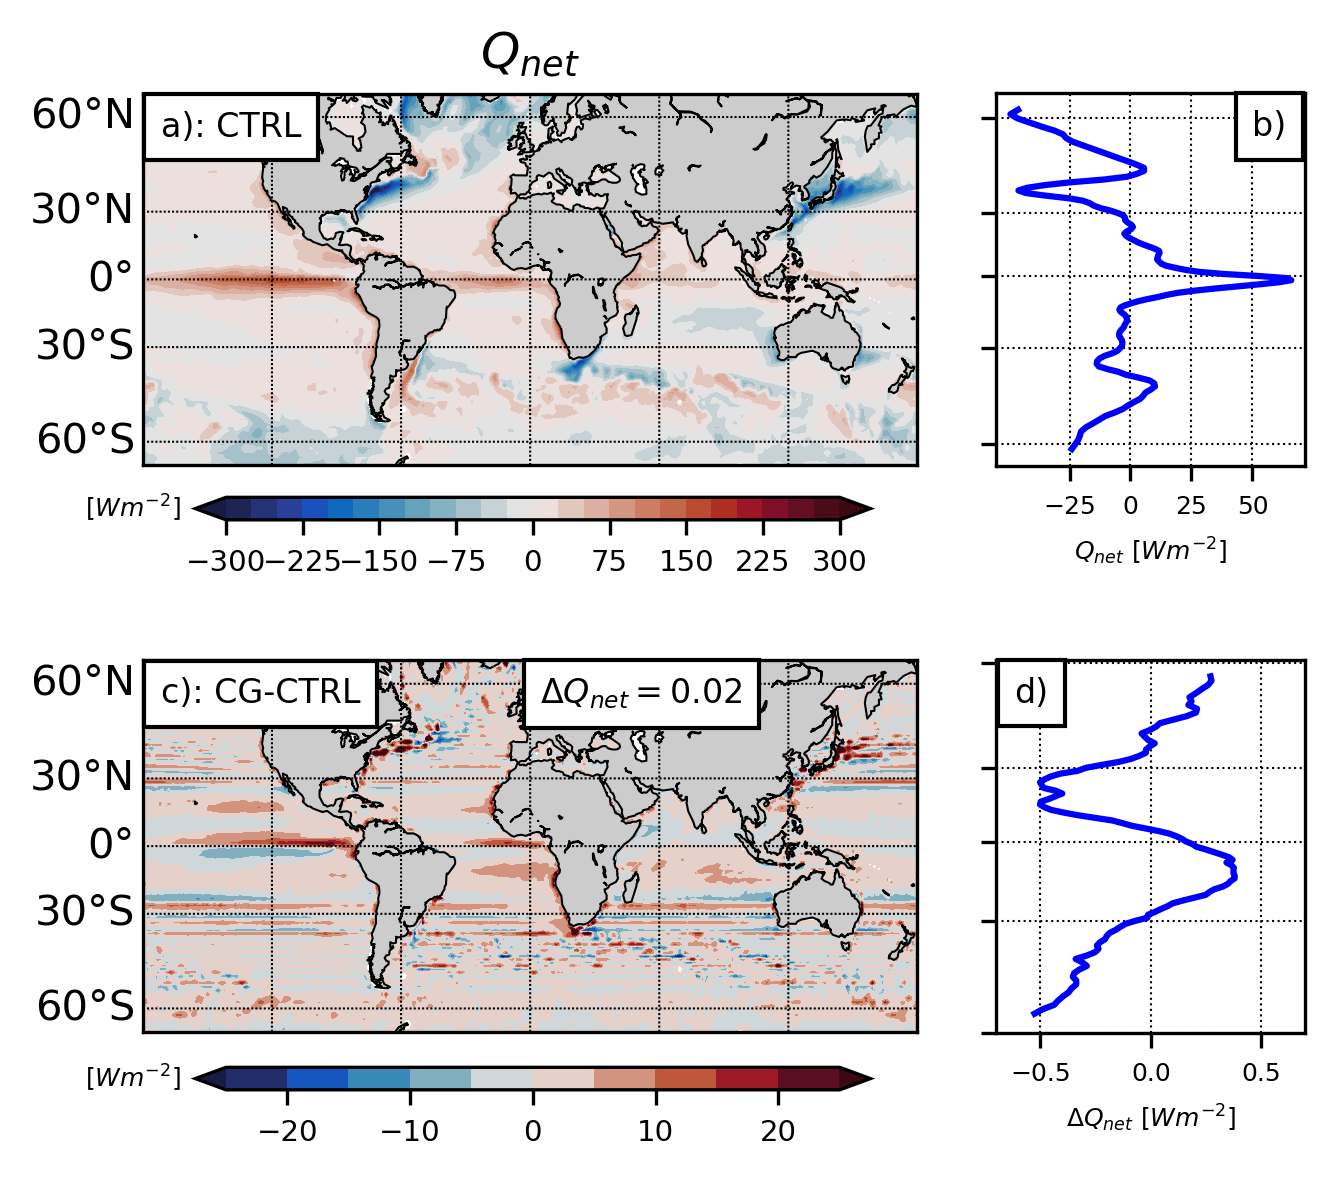

In [21]:
m = Basemap(projection='merc',llcrnrlat=-65,urcrnrlat=65,llcrnrlon=-180,urcrnrlon=180,lat_ts=20,resolution='c')
fig = plt.figure(figsize=(5, 5), dpi=300)
gs = gridspec.GridSpec(200, 150)

                            #a
ax1 = plt.subplot(gs[0:90, 0:100])
levs = np.arange(-300,325,25)

data=np.nanmean(CTRL_HFLX,0)
plt.title(r'$Q_{net}$')

cs=plot_func(data,levs,cm.cm.balance,'both')
cbaxes = fig.add_axes([0.160, 0.55, 0.45, 0.015])
cb = plt.colorbar(cs,cax = cbaxes,orientation="horizontal")
cb.ax.tick_params(labelsize=7)
cb.ax.set_ylabel(r'$[Wm^{-2}]$',fontsize=6,rotation=0,y=-.20,labelpad=+15)
                            #b
ax2 = plt.subplot(gs[12:78, 110:150])
N=2
y1=25
y2=154
x,y=m(lon2[y1:y2,:],lat2[y1:y2,:]) # 65S - 65N
plt.plot(running_mean_1d(np.nanmean(data[y1:y2],1),N),y[:,180],'b')
plt.yticks(y[[2,32,65,94,125],180].tolist())
plt.grid(color='k', ls='dotted', linewidth=0.5)
ax2.axes.yaxis.set_ticklabels([])
plt.xticks([-25,0,25,50],fontsize=6)
plt.xlabel(r'$Q_{net}$ $[Wm^{-2}]$',fontsize=6)
                  
                            #c
ax3 = plt.subplot(gs[100:190, 0:100])
levs = np.arange(-50,60,10)
levs = np.arange(-25,30,5)
data=np.nanmean(CG_HFLX-CTRL_HFLX,0)
cs=plot_func(data,levs,cm.cm.balance,'both')

cbaxes = fig.add_axes([0.160, 0.17, 0.45, 0.015])
cb = plt.colorbar(cs,cax = cbaxes,orientation="horizontal")
cb.ax.tick_params(labelsize=7)
cb.ax.set_ylabel(r'$[Wm^{-2}]$',fontsize=6,rotation=0,y=-.20,labelpad=+15)
                            #d
ax4 = plt.subplot(gs[112:178, 110:150])
N=20#0
data = np.nanmean(np.nanmean(CG_HFLX-CTRL_HFLX,1),0)
y1=25
y2=154
x,y=m(lon2[y1:y2,:],lat2[y1:y2,:]) # 65S - 65N
plt.plot(running_mean_1d(data[y1:y2],N),y[:,180],'b')
plt.yticks(y[[6,36,65,92,121],180].tolist())
ax4.axes.yaxis.set_ticklabels([])
plt.grid(color='k', ls='dotted', linewidth=0.5)
plt.xticks([-0.5,0,0.5],fontsize=6)
plt.xlabel(r'$\Delta Q_{net}$ $[Wm^{-2}]$',fontsize=6)
plt.xlim(-.7,.7)

i=0.023
j=0.910
plt.text(i,j,'a): CTRL',    ha='left',va='center',transform=ax1.transAxes,bbox={'facecolor':'white'},fontsize=8)
plt.text(i+.805,j,'b)',    ha='left',va='center',transform=ax2.transAxes,bbox={'facecolor':'white'},fontsize=8)
plt.text(i,j,'c): CG-CTRL',ha='left',va='center',transform=ax3.transAxes,bbox={'facecolor':'white'},fontsize=8)
delta = float((CTRL_q_net_mean-CG_q_net_mean).mean())
label=r'$\Delta Q_{net}=$' + str(np.round(delta,2))
plt.text(0.513, j,label,ha='left',va='center',transform=ax3.transAxes,bbox={'facecolor':'white'},fontsize=8)
plt.text(i+.035,j,'d)',ha='left',va='center',transform=ax4.transAxes,bbox={'facecolor':'white'},fontsize=8)

plt.savefig('fig3_Qnet.png',dpi=300)

In [8]:
!conda list

# packages in environment at /gpfs/fs6/home-geomar/smomw122/TM/software/miniconda3_20170727/envs/py2_std:
#
alabaster                 0.7.10                   py27_1    conda-forge
anaconda-client           1.6.5                      py_0    conda-forge
aospy                     0.2                      py27_0    conda-forge
asn1crypto                0.22.0                   py27_0    conda-forge
astroid                   1.5.3                    py27_0    conda-forge
babel                     2.5.1                    py27_0    conda-forge
backports                 1.0                      py27_1    conda-forge
backports.functools_lru_cache 1.4                      py27_1    conda-forge
backports.shutil_get_terminal_size 1.0.0                      py_3    conda-forge
backports_abc             0.5                      py27_0    conda-forge
basemap                   1.1.0                    py27_3    conda-forge
basemap-data-hires        1.1.0                         0    conda-forge
big